I am building my own LLM so first I am building a tokenizer of my own 

STEP 1 - CREATE THE TOKENS

In [2]:
with open("01 Harry Potter and the Sorcerers Stone.txt", "r", encoding="Utf-8") as f:
    raw_text = f.read()

print(len(raw_text)) #Total number of characters
print(raw_text[:99])

439478
M r. and Mrs. Dursley, of number four, Privet Drive, were proud to say that they were perfectly nor


In [3]:
import re  #library for splitting
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30]) # Remember this is a list having all the tokens

['M', 'r', '.', 'and', 'Mrs', '.', 'Dursley', ',', 'of', 'number', 'four', ',', 'Privet', 'Drive', ',', 'were', 'proud', 'to', 'say', 'that', 'they', 'were', 'perfectly', 'normal', ',', 'thank', 'you', 'very', 'much', '.']


STEP 2 - CREATE TOKEN ID FOR THIS TOKENS

In [4]:
#now we have to use vocabulary that is the sorted words
words = sorted(set(preprocessed))
vocab_size = len(words)
print(vocab_size)

7572


In [5]:
#Remember vocab is a mapping from tokens to tokenIDs
vocab = {token:integer for integer, token in enumerate(words)}

In [6]:
#enumerate - this I have used to assign integer values to the sorted words
for i, item in enumerate(vocab.items()):
    print(item)
    if i>=50:
        break

('!', 0)
("'", 1)
('(', 2)
(')', 3)
('*', 4)
(',', 5)
('-', 6)
('-bodied', 7)
('.', 8)
('1', 9)
('1473', 10)
('1637', 11)
('17', 12)
('1709', 13)
('1945', 14)
('2', 15)
('3', 16)
('31', 17)
('382', 18)
('4', 19)
(':', 20)
(';', 21)
('?', 22)
('A', 23)
('ALBUS', 24)
('ALLEY', 25)
('ALLOWED', 26)
('AM', 27)
('AND', 28)
('ANYTHING', 29)
('ARE', 30)
('AT', 31)
('About', 32)
('According', 33)
('Adalbert', 34)
('Add', 35)
('Adrian', 36)
('Africa', 37)
('African', 38)
('After', 39)
('Against', 40)
('Ages', 41)
('Agrippa', 42)
('Ah', 43)
('Ahead', 44)
('Alberic', 45)
('Albus', 46)
('Albus…”', 47)
('Algie', 48)
('Alicia', 49)
('All', 50)


WE NEED TO REMEMBER TWO CONCEPTS i.e. ENCODER AND DECODER

ENCODER -> it will take text as input and give token ID as output

DECODER -> it will take token ID as input and will give text as output

In [7]:
class SimpleTokenizer:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

In [8]:
#Now let us create an object of the above class and check if it is returning the ids or not
tokenizer = SimpleTokenizer(vocab)
text =  """It was on the corner of the street that he noticed"""
ids = tokenizer.encode(text)
print(ids)

[593, 6597, 4470, 6131, 2269, 4452, 6131, 5888, 6126, 3488, 4427]


In [9]:
tokenizer.decode(ids)

'It was on the corner of the street that he noticed'

So encoder and decoder is perfectly working as expected

NOW WE HAVE COMPLETED A SIMPLE TOKENIZER OF OUR OWN BUT THERE ARE SOME LIMITATIONS. WE CANNOT USE OTHER TEXT OTHER THAN THE ONE IN THE txt file WE USED MEANING IF I WRITE SOME TEXT THERE WILL BE ERROR SO WE NEED SPECIAL CONTEXT TOKENS WHICH IS ALSO USED BY GPT MODELS .

<|endofText|> and <|unk|> -> unknown will be used

In [10]:
tokens = sorted(list(set(preprocessed)))
tokens.extend(["<|endofText|>", "<|unk|>"])# Here I used extend it will add 2 extra entries see the result it is 7574 but previously it was 7572
vocab = {token:integer for integer, token in enumerate(tokens)}
len(vocab.items())

7574

Let us check 

In [11]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('…Oak', 7569)
('…Then', 7570)
('…”', 7571)
('<|endofText|>', 7572)
('<|unk|>', 7573)


In [12]:
class AdvancedTokenizer:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self,text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
    
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

Now let us try again with some random text

In [13]:
tokenizer = AdvancedTokenizer(vocab)

text1 = "Hello, my name is Subhranil Mondal"
text2 = "I am from Kolkata."

text = " <|endofText|> ".join((text1,text2))
print(text)

Hello, my name is Subhranil Mondal <|endofText|> I am from Kolkata.


In [14]:
tokenizer.encode(text)

[7573, 5, 4318, 4332, 3758, 7573, 7573, 7572, 575, 1391, 3164, 7573, 8]

In [15]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, my name is <|unk|> <|unk|> <|endofText|> I am from <|unk|>.'

See this is a word based tokenizer but GPT uses subword tokenizer so for that we need Byte Pair encoder

In [16]:
#we will be using the BPE tokenizer which OpenAI uses
! pip3 install tiktoken


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
import importlib
import tiktoken

In [18]:
tokenizer = tiktoken.get_encoding("gpt2")

In [19]:
#Let us test

text = "Hello, my name is Subhranil Mondal. I am from Kolkata."
integers = tokenizer.encode(text, allowed_special={"<|endofText|>"})
print(integers)

[15496, 11, 616, 1438, 318, 3834, 16848, 346, 27328, 282, 13, 314, 716, 422, 509, 13597, 1045, 13]


In [20]:
s = tokenizer.decode(integers)
print(s)

Hello, my name is Subhranil Mondal. I am from Kolkata.


Therefore encoder and decoder is working pretty well

Now, we have to create Input-Target pairs
But what is it?
see we need to do self supervised learning kind of unsupervised. The data are not labeled here . LLM will be feed one word and it will predict next one This is what we gonna implement which the GPT does.

In [21]:
with open("01 Harry Potter and the Sorcerers Stone.txt", "r", encoding="Utf-8") as f:
    raw_text = f.read()

encoded_text = tokenizer.encode(raw_text)
print(len(encoded_text))

124336


In [22]:
sample = encoded_text[50:]

In [23]:
conSize = 4 #context size -> length of input sequence
x = sample[:conSize]
y = sample[1:conSize+1]
print(f"x: {x}")
print(f"y: {y}")

x: [11428, 11, 780, 484]
y: [11, 780, 484, 655]


In [24]:
for i in range(1, conSize+1):
    context = sample[:i]
    desired = sample[i]

    print(context, "->", desired)

[11428] -> 11
[11428, 11] -> 780
[11428, 11, 780] -> 484
[11428, 11, 780, 484] -> 655


Now just decode it

In [25]:
for i in range(1, conSize+1):
    context = sample[:i]
    desired = sample[i]

    print(tokenizer.decode(context), "->", tokenizer.decode([desired]))

 mysterious -> ,
 mysterious, ->  because
 mysterious, because ->  they
 mysterious, because they ->  just


so now we have to turn tokens into embeddings and implement a data loader as inputs and PyTorch Tensors as target like you can think about multidimensional arrays.

STEP 3 - IMPLEMENT A DATALOADER(WE WILL BE USING PYTORCH)

In [26]:
! pip3 install torch torchvision torchaudio


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        # Step 1 - we will tokenize the entire text
        token_ids = tokenizer.encode(txt,allowed_special={"<|endofText|>"})
        # Step 2 - we will use sliding window to chunk the book into overlapping sequences
        for i in range(0, len(token_ids)-max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    # Step 3 - Then return the total no. of rows
    def __len__(self):
        return len(self.input_ids)
    
    # Step 4 - Return a single row from the datset
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [28]:
# Now we have to create the data loader
def create_dataloader(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)
    return dataloader

Now Let us Test

In [29]:
with open("01 Harry Potter and the Sorcerers Stone.txt", "r", encoding="Utf-8") as f:
    raw_text = f.read()

In [30]:
# Now I am gonna convert dataloader into a python iterator to fetch the next entry

import torch
dataloader = create_dataloader(raw_text, batch_size=1, max_length=4, stride=1, shuffle=False)
iter_data = iter(dataloader)
first_batch = next(iter_data)
print(first_batch)

[tensor([[ 44, 374,  13, 290]]), tensor([[ 374,   13,  290, 9074]])]


see as we used stride=1 so it will overlap so doing this will make the model overfit and noisy .Lets see if we use stride=4 and increase batch_size to 8

In [31]:
dataloader = create_dataloader(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)
iter_data = iter(dataloader)
inputs, targets = next(iter_data)
print("\nInputs:\n", inputs)
print("\nTargets:\n", targets)


Inputs:
 tensor([[   44,   374,    13,   290],
        [ 9074,    13,   360,  1834],
        [ 1636,    11,   286,  1271],
        [ 1440,    11,  4389, 16809],
        [ 9974,    11,   547,  6613],
        [  284,   910,   326,   484],
        [  547,  7138,  3487,    11],
        [ 5875,   345,   845,   881]])

Targets:
 tensor([[  374,    13,   290,  9074],
        [   13,   360,  1834,  1636],
        [   11,   286,  1271,  1440],
        [   11,  4389, 16809,  9974],
        [   11,   547,  6613,   284],
        [  910,   326,   484,   547],
        [ 7138,  3487,    11,  5875],
        [  345,   845,   881,    13]])


batch size = 8 means the input tensors are also 8 rows

Now let us create token or vector embeddings

In [32]:
input_ids = torch.tensor([2,3,5,1])

FOR SIMPLICITY WE WILL USE VOCAB SIZE 6

In [33]:
vocab_size = 6
output_dim = 3 # Output dimensions
# Output will be a 6 X 3 matrix
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)
print(embedding_layer(input_ids))

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)
tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


Now see this is just a basic implementation of token embedding but this is not the right way. we meed to have the concept of positional embeddings -> absolute and relative. GPT or any other transfromer uses absolute embeddings

In [34]:
vocab_size = 50257 #Lets give the actual vocab_size for GPT2
output_dim = 256 #Lets keep it 256
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [35]:
#Now let us create the data loader again
max_length = 4
dataloader = create_dataloader(raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [36]:
print("\nInput IDs:\n", inputs)
print("\nTarget IDs:\n", targets)
print("\nInputs shape:", inputs.shape) # 8 x 4 tensor


Input IDs:
 tensor([[   44,   374,    13,   290],
        [ 9074,    13,   360,  1834],
        [ 1636,    11,   286,  1271],
        [ 1440,    11,  4389, 16809],
        [ 9974,    11,   547,  6613],
        [  284,   910,   326,   484],
        [  547,  7138,  3487,    11],
        [ 5875,   345,   845,   881]])

Target IDs:
 tensor([[  374,    13,   290,  9074],
        [   13,   360,  1834,  1636],
        [   11,   286,  1271,  1440],
        [   11,  4389, 16809,  9974],
        [   11,   547,  6613,   284],
        [  910,   326,   484,   547],
        [ 7138,  3487,    11,  5875],
        [  345,   845,   881,    13]])

Inputs shape: torch.Size([8, 4])


Each token ID is now embedded as a 256- dimensional vector

Now let us create an embedding layer

In [37]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [38]:
context_length = max_length
# no.of rows = context_length and no.of columns = output_dim
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

In [39]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
#Here torch.arange is creating a sequence of numbers from 0 to max_length-1
print(pos_embeddings.shape)

torch.Size([4, 256])


Now let us add the 4x256 dimensional tensor to each 4x256 token embeddings

In [40]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


Now Let us Implement a Simplified Attention Mechanism

In [41]:
import torch
# we are choosing a small embedding dimension for now but it can be replicated for higher dimension space as well
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

Just showing the plotting diagram

In [42]:
! pip3 install matplotlib 


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


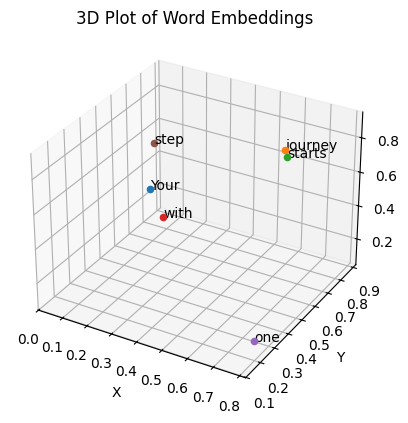

In [43]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

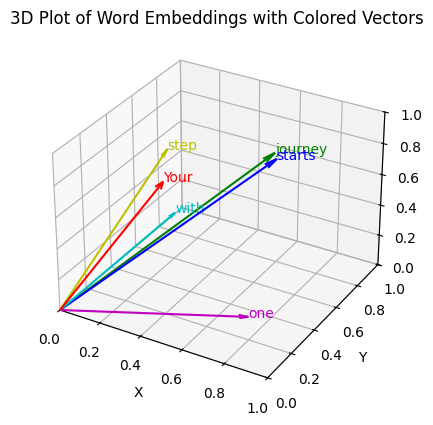

In [44]:
# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


In [45]:
query = inputs[1] #2nd token "journey"
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x, query) # Taking dot product of each word vector with the query vector

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Now we will implement Normalization to make the LLM stabe

In [46]:
final_tensor = attn_scores_2 / attn_scores_2.sum()
print(final_tensor)
print("sum:", final_tensor.sum())

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
sum: tensor(1.0000)


The above approach is not that good so we must use softmax function instead (pytorch)

[e^(x1-max)/sum , e^(x2-max)/sum ,e^(x3-max)/sum  , ...]  

=> [e^(x1-max) + e^(x2-max) + e^(x3-max)+ ...]

In [47]:
weights = torch.softmax(attn_scores_2, dim=0)
print(weights)
print("sum of weights:", weights.sum())

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
sum of weights: tensor(1.)


Now we need to calculate the context vector which is the enriched embedding vector of journey here as it is query now see this context vector is summation of all other vectors as well .

In [48]:
query = inputs[1]
context_vector_2 = torch.zeros(query.shape)
for i, x in enumerate(inputs):
    context_vector_2 += weights[i] * x

print(context_vector_2)

tensor([0.4419, 0.6515, 0.5683])


Now let us see visually

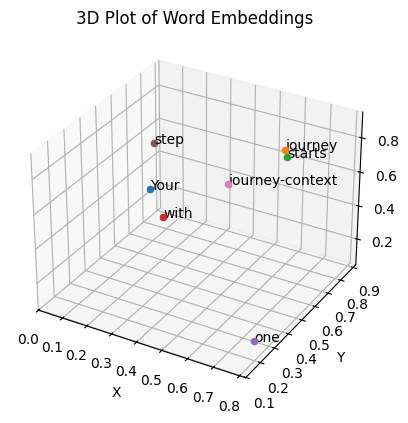

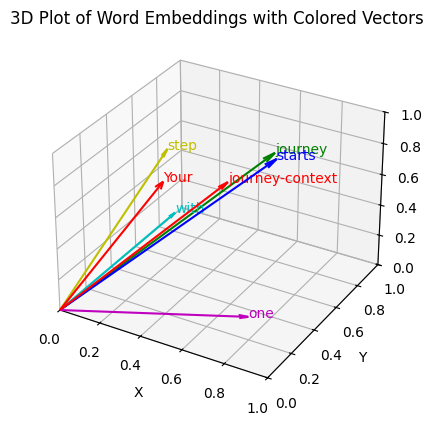

In [49]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55], # step     (x^6)
   [0.4419, 0.6515, 0.5683]]
)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot each point and annotate with corresponding word
for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax.scatter(x, y, z)
    ax.text(x, y, z, word, fontsize=10)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('3D Plot of Word Embeddings')
plt.show()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'r']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()

Now let us calculate attention weights and context vectors for all inputs

In [50]:
# I have harcoded this stuff let us do it like this 
n = len(inputs)
attn_scores = torch.empty(n,n)
for i, x in enumerate(inputs):
    for j, y in enumerate(inputs):
        attn_scores[i,j] = torch.dot(x,y)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310, 0.7935],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865, 1.1849],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605, 1.1694],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565, 0.6626],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935, 0.5600],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450, 0.8559],
        [0.7935, 1.1849, 1.1694, 0.6626, 0.5600, 0.8559, 0.9427]])


In [51]:
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

tensor([[0.1792, 0.1713, 0.1692, 0.1061, 0.1042, 0.1240, 0.1459],
        [0.1180, 0.2026, 0.1986, 0.1056, 0.0921, 0.1346, 0.1486],
        [0.1184, 0.2017, 0.1981, 0.1058, 0.0943, 0.1332, 0.1485],
        [0.1223, 0.1768, 0.1744, 0.1246, 0.1077, 0.1467, 0.1476],
        [0.1305, 0.1675, 0.1689, 0.1169, 0.1607, 0.1108, 0.1446],
        [0.1180, 0.1861, 0.1813, 0.1211, 0.0842, 0.1615, 0.1478],
        [0.1277, 0.1889, 0.1860, 0.1121, 0.1011, 0.1359, 0.1483]])


In [52]:
context_vectors = attn_weights @ inputs
print(context_vectors)

tensor([[0.4420, 0.6016, 0.5774],
        [0.4419, 0.6515, 0.5683],
        [0.4429, 0.6499, 0.5673],
        [0.4321, 0.6330, 0.5536],
        [0.4635, 0.5997, 0.5326],
        [0.4213, 0.6505, 0.5651],
        [0.4397, 0.6372, 0.5635]])


Now I wil implement self-attention mechanism previously we did only a simple attention mechanism.

for this we need to dicide the input matrix into thre trainable weight matrices one for query, one for key and another for value.

In [53]:
import torch
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

In [54]:
x_2 = inputs[1] #second input element
d_in = inputs.shape[1] #input embedding size, d=3
d_out = 2 #output embedding size, d_out = 2

In [55]:
#Let us initialize the three weight matrices Wq, Wk, Wv
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [56]:
print("W_query:\n", W_query)

W_query:
 Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [57]:
print(W_key)

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])


In [58]:
print(W_value)

Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])


now we just need to multiply the input vectors with these weight matrices to get the query, key and value vectors

In [59]:
#But first let us compute the query, key and value vectors for the second input element
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print("query_2:", query_2)  # results in a 2D vector

query_2: tensor([0.4306, 1.4551])


In [60]:
keys = inputs @ W_key
values = inputs @ W_value
queries = inputs @ W_query
print(keys.shape)
print(values.shape)
print(queries.shape)

torch.Size([6, 2])
torch.Size([6, 2])
torch.Size([6, 2])


Now we have successfully projected the 6 input tokens from a 3D onto a 2D embedding space

Now let us calculate the attention scores

In [61]:
keys_2 = keys[1] # for the second input element
attn_scores_22 = query_2.dot(keys_2)
print(attn_scores_22)

tensor(1.8524)


In [62]:
attn_scores_2 = query_2 @ keys.T  # query_2 is 1 X 2 and keys.T is 2 X 6 so the result will be 1 X 6
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


Now let us do it for all queries

In [63]:
attn_scores = queries @ keys.T
print(attn_scores)

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])


Let us scale the attention scores by dividing them by the sq.root of the keys_dimension

In [64]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / (d_k**0.5), dim=-1)
print(attn_weights_2)
print(d_k)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
2


Now we have to calculate the final context vector
context_vec = attention_weights * values

In [65]:
import torch.nn as nn
class SelfAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1]**0.5), dim=-1)
        context_vectors = attn_weights @ values
        return context_vectors

In [66]:
torch.manual_seed(123)
self_attn = SelfAttention(d_in, d_out)
print(self_attn(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


Previous approach can be improved using linear instaed of parameter


In [67]:
class SelfAttention_final_version(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / (keys.shape[-1]**0.5), dim=-1)
        context_vectors = attn_weights @ values
        return context_vectors

In [68]:
torch.manual_seed(789)
self_attn_v2 = SelfAttention_final_version(d_in, d_out)
print(self_attn_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [70]:
queries = self_attn_v2.W_query(inputs)
keys = self_attn_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Now let us create a mask where the values above the diagonal are zero

In [71]:
context_length = attn_scores.shape[0]
mask = torch.tril(torch.ones(context_length, context_length))
print(mask)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


Let us renormalize the weights to sum up to 1

In [72]:
row_sums = mask.sum(dim=1, keepdim=True)
mask_norm = mask / row_sums
print(mask_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667]])


above code may rise to dataleakage instead lets do something efficient

In [74]:
print(attn_scores)

tensor([[ 0.2899,  0.0716,  0.0760, -0.0138,  0.1344, -0.0511],
        [ 0.4656,  0.1723,  0.1751,  0.0259,  0.1771,  0.0085],
        [ 0.4594,  0.1703,  0.1731,  0.0259,  0.1745,  0.0090],
        [ 0.2642,  0.1024,  0.1036,  0.0186,  0.0973,  0.0122],
        [ 0.2183,  0.0874,  0.0882,  0.0177,  0.0786,  0.0144],
        [ 0.3408,  0.1270,  0.1290,  0.0198,  0.1290,  0.0078]],
       grad_fn=<MmBackward0>)


In [76]:
maskf = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(maskf.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


Now we need to apply the softmax func to these results

In [77]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


Now we will implement dropout technique of about 50% for now later we will try to lower this

In [80]:
torch.manual_seed(123)
dropout = nn.Dropout(0.5)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


This is the casual attention and dropout masking mechanism now lets implement a casuatAttention class

In [ ]:
#Lets create a batch
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) # each token is a 3D embedding vector

torch.Size([2, 6, 3])


In [82]:
class CasualAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias = False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)  
        queries = self.W_query(x) 
        values = self.W_value(x) 

        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(self.mask.bool() [:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ values
        return context_vectors


In [83]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CasualAttention(d_in, d_out, context_length, 0.0)
context_vectors = ca(batch)
print(context_vectors.shape)

torch.Size([2, 6, 2])


In [84]:
print(context_vectors)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)
